# Suppressing instability on a Vlasov-Poisson system with an external electric field
## Example: Two stream distribution

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import jax
Array = jax.Array
import jax.numpy as jnp
import jax.scipy as jsp
from jax.scipy import optimize
import scipy.stats
import dataclasses
from functools import partial
from typing import Callable, Union

from ott.geometry import geometry, pointcloud
from ott.problems.linear import linear_problem
from ott.solvers.linear import sinkhorn

import jaxopt

from VP_solver.jax_vp_solver import Mesh, make_mesh, VlasovPoissonSolver

matplotlib.rcParams.update({
    'font.size': 14,  # General font size
    'axes.labelsize': 14,  # Axis label size
    'axes.titlesize': 14,  # Title size
    'xtick.labelsize': 14,  # X-tick label size
    'ytick.labelsize': 14,  # Y-tick label size
    'legend.fontsize': 14   # Legend font size
})

print(jax.devices())

[CudaDevice(id=0)]


### Problem setup and solver setup

In [2]:
# Setup
nx = 256
nv = 256
dt = 0.1
t_final = 30  # Adjusted for demonstration purposes
L = 10 * jnp.pi
LV = 6.0

In [3]:
mesh = make_mesh(L, LV, nx, nv)

alpha = 0.5
mu1 = 2.4
mu2 = -2.4
f_eq = (alpha * jnp.exp(-0.5 * (mesh.V - mu1)**2) + (1 - alpha) * jnp.exp(-0.5 * (mesh.V - mu2)**2)) / jnp.sqrt(2 * jnp.pi)
epsilon = 0.001
k_0 = 0.2
f_iv = (1.0 + epsilon * jnp.cos(k_0 * mesh.X)) * f_eq

In [4]:
# Function to compute the external field H (not time-dependent)
def compute_external_field(ak, mesh):
    k = jnp.arange(1, len(ak[0,:]) + 1)  # Create an array of k values from 1 to len(a_k)
    H = ak[0,:] @ jnp.cos(k[:, None] * mesh.xs / mesh.period_x * 2 * jnp.pi) \
            + ak[1,:] @ jnp.sin(k[:, None] * mesh.xs / mesh.period_x * 2 * jnp.pi)  # Vectorized computation
    return H
    
### Plotting functions
# Function to plot the distribution of f_eq over x and v
def plot_feq_distribution(fig, ax, f_eq, title):
    im = ax.imshow(f_eq.transpose(), extent=[mesh.xs[0], mesh.xs[-1], mesh.vs[0], mesh.vs[-1]], aspect='auto', cmap='plasma')  # 'auto' aspect ratio
    ax.set_title(title)
    ax.set_xlabel('$x$')
    ax.set_ylabel('$v$')
    fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)  # Adjusted colorbar size

# Modify the plot_distribution function to handle 2D data
def plot_distribution(fig, ax, data, title, time):
    im = ax.imshow(data.T, extent=[mesh.xs[0], mesh.xs[-1], mesh.vs[0], mesh.vs[-1]], aspect='auto', cmap='plasma')  # Transpose data
    ax.set_title(f'{title} (t={time:.2f})')
    ax.set_xlabel('$x$')
    ax.set_ylabel('$v$')
    fig.colorbar(im, ax=ax)#, fraction=0.046, pad=0.04)  # Adjusted colorbar size

In [5]:
solver = VlasovPoissonSolver(mesh=mesh, dt=dt, f_eq=f_eq)

# JIT-compiled forward solver
solver_jit = jax.jit(solver.run_forward_jax_scan, static_argnames=('t_final',))

In [6]:
# External field parameters (coefficients for the cosine terms)
k_total = 14
ak1 = jax.random.uniform(jax.random.key(888), (2,k_total), minval=-1.0, maxval=1.0)
ak2 = jax.random.uniform(jax.random.key(0), (2,k_total), minval=-1.0, maxval=1.0)
#a_k = jnp.array([
#    3.5164488e-04, 9.0411077e-06, -3.1953386e-05, -6.0834586e-06,
#    5.8570990e-06, 6.0852408e-06, -2.7067827e-06, -8.1664248e-06,
#    -8.8577590e-06, -9.7180082e-06, -9.5229143e-06, -9.5641644e-06,
#    -8.8652696e-06, -8.6681093e-06, -7.7312543e-06])
#b_k = jnp.array([-9.6406386e-04,
#    -5.9252861e-04, 2.9924628e-05, 4.2226049e-05, 5.3339943e-05,
#    3.5979556e-05, 2.5546415e-05, 1.0124806e-05, 6.6790512e-06,
#    1.3618927e-06, 3.0158180e-06, 7.7909431e-07, 3.0062322e-06,
#    1.2950333e-06, 3.2279252e-06])

#ak = jnp.stack([a_k, b_k])

# Compute the external field
H1 = compute_external_field(ak1, mesh)
H2 = compute_external_field(ak2, mesh)

# num_steps = int(t_final / dt)

In [7]:
f_array1, E_array1, ee_array1 = solver_jit(f_iv, H1, t_final=t_final)

f_array2, E_array2, ee_array2 = solver_jit(f_iv, H2, t_final=t_final)

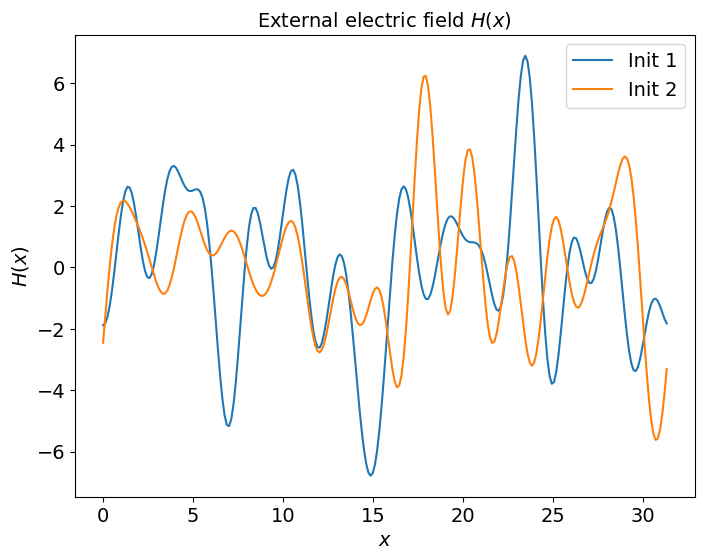

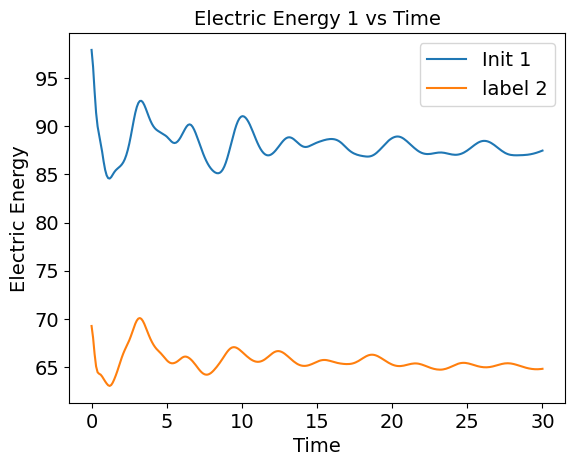

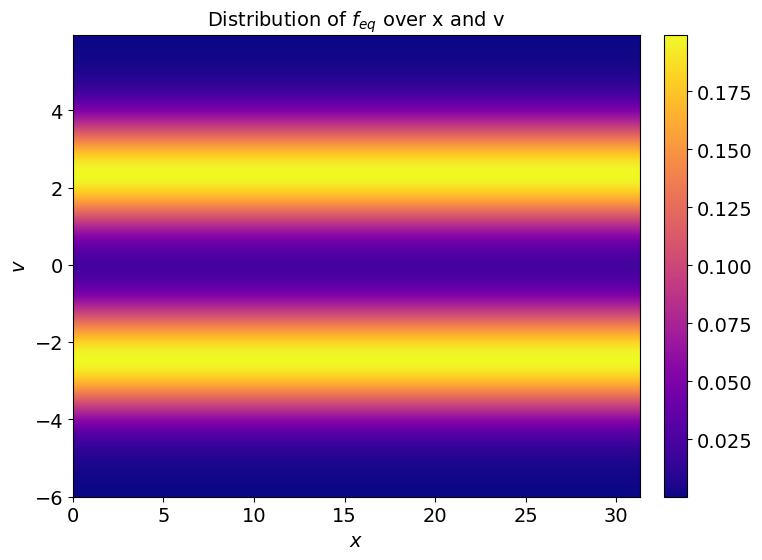

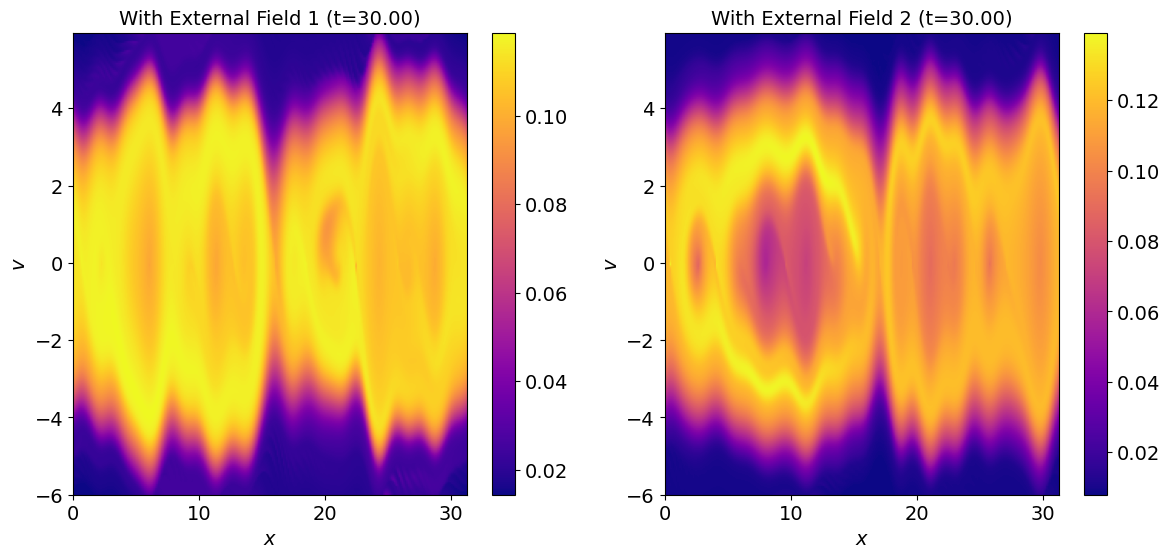

In [8]:
# Create a figure with a single plot for electric energy
fig, ax = plt.subplots(figsize=(8, 6))
t_values = jnp.linspace(0, t_final, int(t_final / dt))


#fig, axs = plt.subplots(2, 2)

plt.plot(mesh.xs, H1, label='Init 1')
plt.plot(mesh.xs, H2, label='Init 2')
plt.xlabel('$x$')
plt.ylabel('$H(x)$')
plt.title('External electric field $H(x)$')
plt.legend()
plt.show()

plt.plot(t_values, ee_array1, label='Init 1')
plt.plot(t_values, ee_array2, label='label 2')
plt.xlabel('Time')
plt.ylabel('Electric Energy')
plt.title('Electric Energy 1 vs Time')
plt.legend()
#plt.grid(True)
plt.show()
         
# Create a figure with a single plot for f_eq
fig, ax = plt.subplots(figsize=(8, 6))

# Plot the distribution of f_eq over x and v
plot_feq_distribution(fig, ax, f_eq, 'Distribution of $f_{eq}$ over x and v')

plt.show()

# Create a figure with a single plot
fig, axs = plt.subplots(1,2 ,figsize=(14, 6))

# f_array is already a 2D array, so pass it directly to the plot
plot_distribution(fig, axs[0], f_array1, 'With External Field 1', t_final)

plot_distribution(fig, axs[1], f_array2, 'With External Field 2', t_final)
plt.show()

### Optimization: finding the coefficients of the external electric field to suppress instability

#### $L^{2}$ objecive function

In [9]:
# Optimization through auto-differentiation with fixed basis.

# Adjust the J function to use f_final
def L2(f_final, solver):
    return jnp.sum((f_final - solver.f_eq) ** 2) * solver.mesh.dx * solver.mesh.dv

# Define the cost function using JAX
def cost_function_L2(a_k):
    H = compute_external_field(a_k, mesh)
    # JIT-compiled forward solver
    #solver_jit = jax.jit(solver.run_forward_jax_scan, static_argnames=('t_final',))
    f_array, E_array, ee_array = solver_jit(f_iv, H, t_final)
    #f_final = f_array
    cost = L2(f_array, solver)
    return cost

In [10]:
maxiter = 2000
solver_opt = jaxopt.LBFGS(fun=cost_function_L2, maxiter=maxiter)


# Define a scan function to iterate with `jax.lax.scan`
def scan_fn(carry, _):
    x, state = carry
    x, state = solver_opt.update(x, state)
    obj_value = cost_function_L2(x)
    return (x, state), obj_value

In [11]:
# Initial point and state
# External field parameters (coefficients for the cosine terms)
# Initial guess for the coefficients
k_total = 14
ak_init_1 = jax.random.uniform(jax.random.key(888), (2, k_total), minval=-1.0, maxval=1.0)
init_state = solver_opt.init_state(ak_init_1)

# Run the optimization and collect objective values using `scan`
res_opt_l2_1, objective_values_l2_1 = jax.lax.scan(scan_fn, (ak_init_1, init_state), None, length=solver_opt.maxiter)



ak_opt_l2_1, state = res_opt_l2_1

In [12]:
# Initial point and state
# External field parameters (coefficients for the cosine terms)
# Initial guess for the coefficients
k_total = 14
ak_init_2 = jax.random.uniform(jax.random.key(0), (2, k_total), minval=-1.0, maxval=1.0)
init_state = solver_opt.init_state(ak_init_2)

# Run the optimization and collect objective values using `scan`
res_opt_l2_2, objective_values_l2_2 = jax.lax.scan(scan_fn, (ak_init_2, init_state), None, length=solver_opt.maxiter)



ak_opt_l2_2, state = res_opt_l2_2

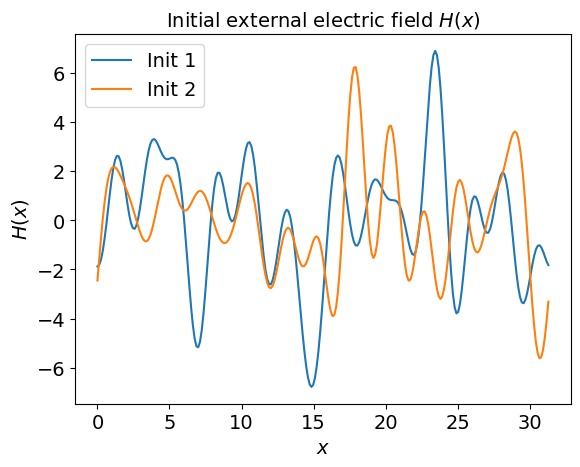

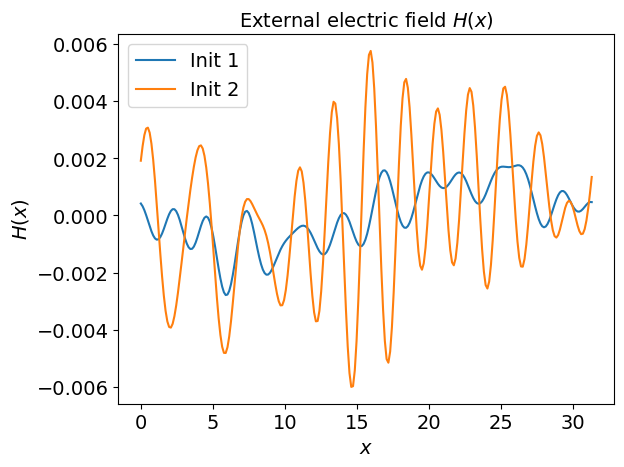

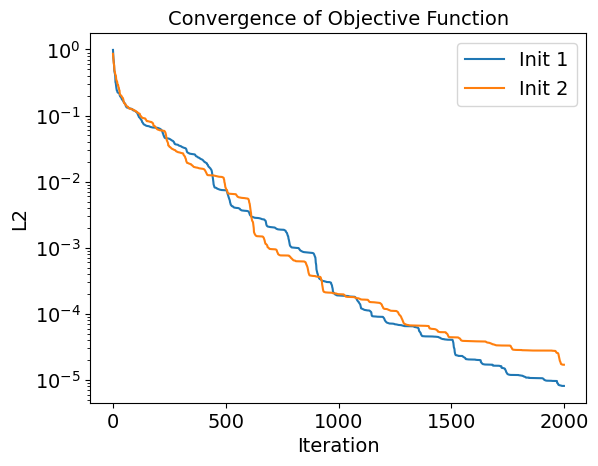

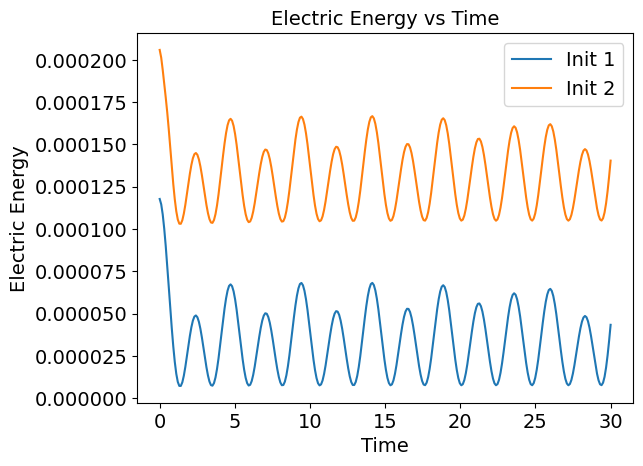

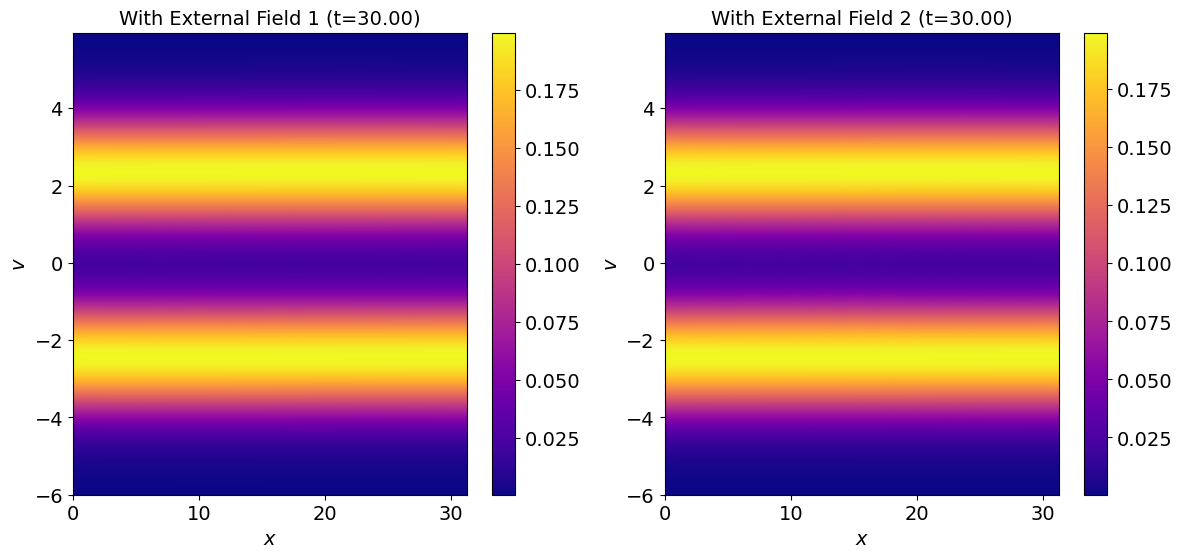

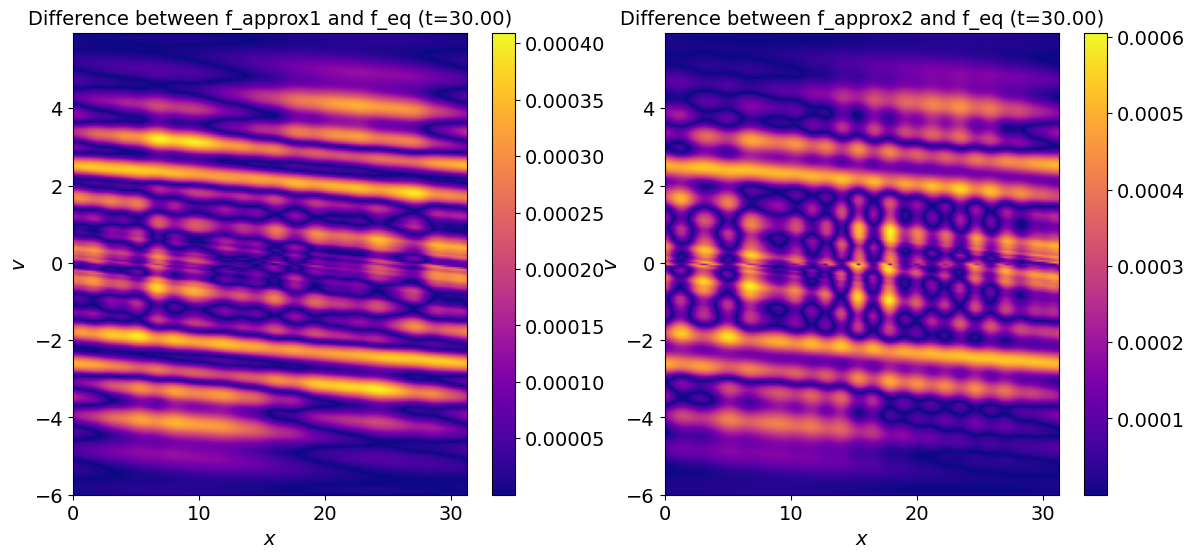

In [13]:
H_init_1 = compute_external_field(ak_init_1, mesh)
H_init_2 = compute_external_field(ak_init_2, mesh)
H_l2_1 = compute_external_field(ak_opt_l2_1, mesh)
H_l2_2 = compute_external_field(ak_opt_l2_2, mesh)
ff_array1, E_array1, ee_array1 = solver.run_forward_jax_scan(f_iv, H_l2_1, t_final)
ff_array2, E_array2, ee_array2 = solver.run_forward_jax_scan(f_iv, H_l2_2, t_final)
    
f_final1 = ff_array1
f_final2 = ff_array2

plt.plot(mesh.xs, H_init_1, label='Init 1')
plt.plot(mesh.xs, H_init_2, label='Init 2')
plt.xlabel('$x$')
plt.ylabel('$H(x)$')
plt.title('Initial external electric field $H(x)$')
plt.legend()
plt.show()

plt.plot(mesh.xs, H_l2_1, label='Init 1')
plt.plot(mesh.xs, H_l2_2, label='Init 2')
plt.xlabel('$x$')
plt.ylabel('$H(x)$')
plt.title('External electric field $H(x)$')
plt.legend()
plt.show()

# Plot the convergence
#objective_values_l2 = jax.device_get(objective_values_l2)  # Move from device to host
plt.plot(objective_values_l2_1, label='Init 1')
plt.plot(objective_values_l2_2, label='Init 2')
plt.yscale('log')
plt.xlabel("Iteration")
plt.ylabel("L2")
plt.title("Convergence of Objective Function")
plt.legend()
plt.show()


plt.plot(t_values, ee_array1, label='Init 1')
plt.plot(t_values, ee_array2, label='Init 2')
plt.xlabel('Time')
plt.ylabel('Electric Energy')
plt.title('Electric Energy vs Time')
plt.legend()
#plt.grid(True)
plt.show()

# Create a figure for two subplots
fig, axs = plt.subplots(1,2 ,figsize=(14, 6))


plot_distribution(fig, axs[0], f_final1, 'With External Field 1', t_final)
plot_distribution(fig, axs[1], f_final2, 'With External Field 2', t_final)

plt.show()

fig, axs = plt.subplots(1,2 ,figsize=(14, 6))

plot_distribution(fig, axs[0], jnp.abs(f_final1 - f_eq), 'Difference between f_approx1 and f_eq', t_final)
plot_distribution(fig, axs[1], jnp.abs(f_final2 - f_eq), 'Difference between f_approx2 and f_eq', t_final)
plt.show()

### $KL$ objective function

In [14]:
# Optimization through auto-differentiation with fixed basis.

def kl_divergence(f_final, solver, eps=1e-8):
    # Normalize the distributions so they sum to 1
    f_final = f_final / (jnp.sum(f_final) * solver.mesh.dx * solver.mesh.dv + eps)
    f_eq = solver.f_eq / (jnp.sum(solver.f_eq) * solver.mesh.dx * solver.mesh.dv + eps)
    
    # Compute KL divergence, adding eps to avoid log(0)
    kl_div = jnp.sum(jax.scipy.special.rel_entr(f_final, f_eq + eps) * solver.mesh.dx * solver.mesh.dv)
    #kl_div = jnp.sum(f_final * jnp.log(f_final / (f_eq + eps) + eps)) * solver.mesh.dx * solver.mesh.dv
    return kl_div

def cost_function_kl(a_k):
    H = compute_external_field(a_k, mesh)
    # JIT-compiled forward solver
    #solver_jit = jax.jit(solver.run_forward_jax_scan, static_argnames=('t_final',))
    f_array, E_array, ee_array = solver_jit(f_iv, H, t_final)
    #f_final = f_array
    cost = kl_divergence(f_array, solver)
    return cost


In [15]:
maxiter = 2000
solver_opt = jaxopt.LBFGS(fun=cost_function_kl, maxiter=maxiter)

# Define a scan function to iterate with `jax.lax.scan`
def scan_fn(carry, _):
    x, state = carry
    x, state = solver_opt.update(x, state)
    obj_value = cost_function_kl(x)
    return (x, state), obj_value

In [16]:
# Initial point and state
# External field parameters (coefficients for the cosine terms)
# Initial guess for the coefficients
k_total = 14
ak_init_1 = jax.random.uniform(jax.random.key(888), (2, k_total), minval=-1.0, maxval=1.0)
init_state = solver_opt.init_state(ak_init_1)


# Run the optimization and collect objective values using `scan`
res_opt_kl_1, objective_values_kl_1 = jax.lax.scan(scan_fn, (ak_init_1, init_state), None, length=solver_opt.maxiter)


ak_opt_kl_1, state = res_opt_kl_1

In [17]:
# Initial point and state
# External field parameters (coefficients for the cosine terms)
# Initial guess for the coefficients
k_total = 14
ak_init_2 = jax.random.uniform(jax.random.key(0), (2, k_total), minval=-1.0, maxval=1.0)
init_state = solver_opt.init_state(ak_init_2)


# Run the optimization and collect objective values using `scan`
res_opt_kl_2, objective_values_kl_2 = jax.lax.scan(scan_fn, (ak_init_2, init_state), None, length=solver_opt.maxiter)


ak_opt_kl_2, state = res_opt_kl_2

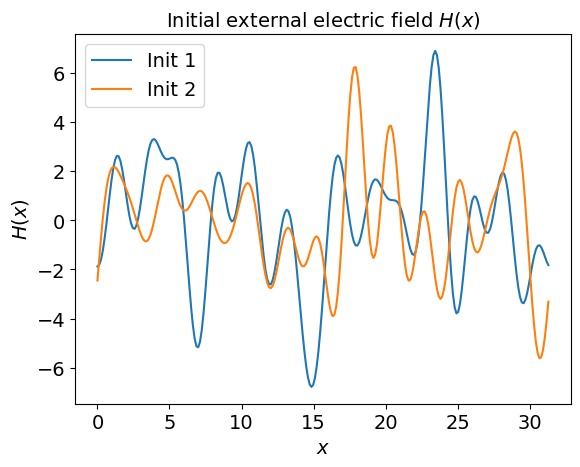

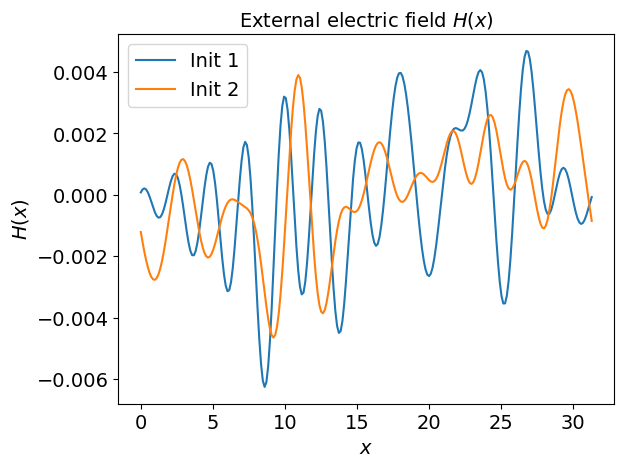

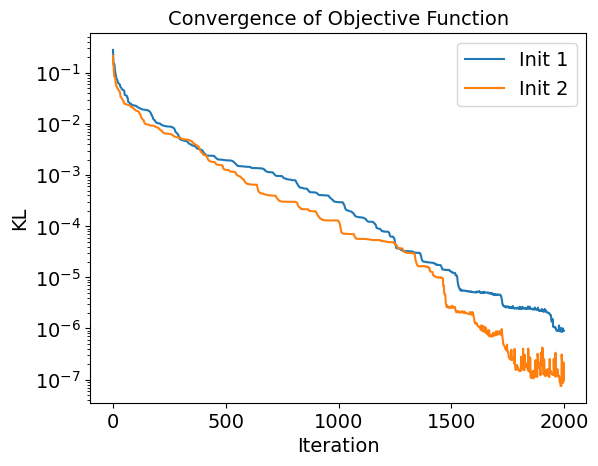

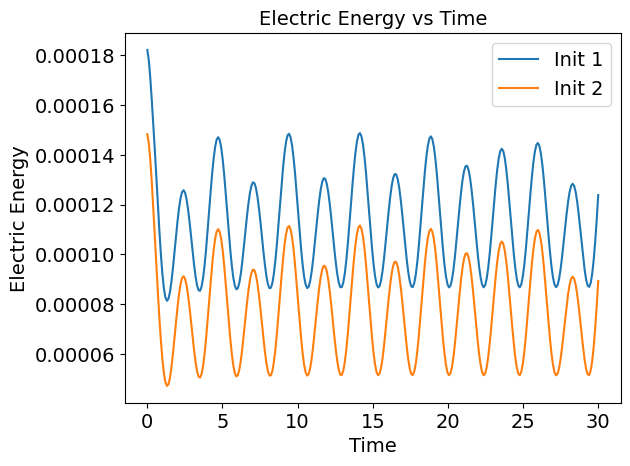

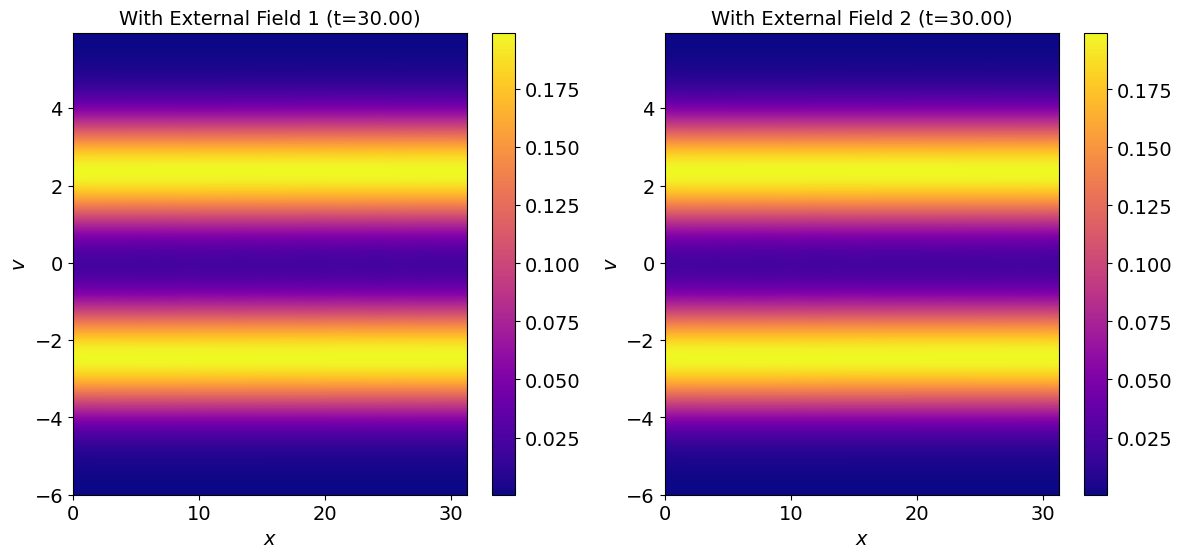

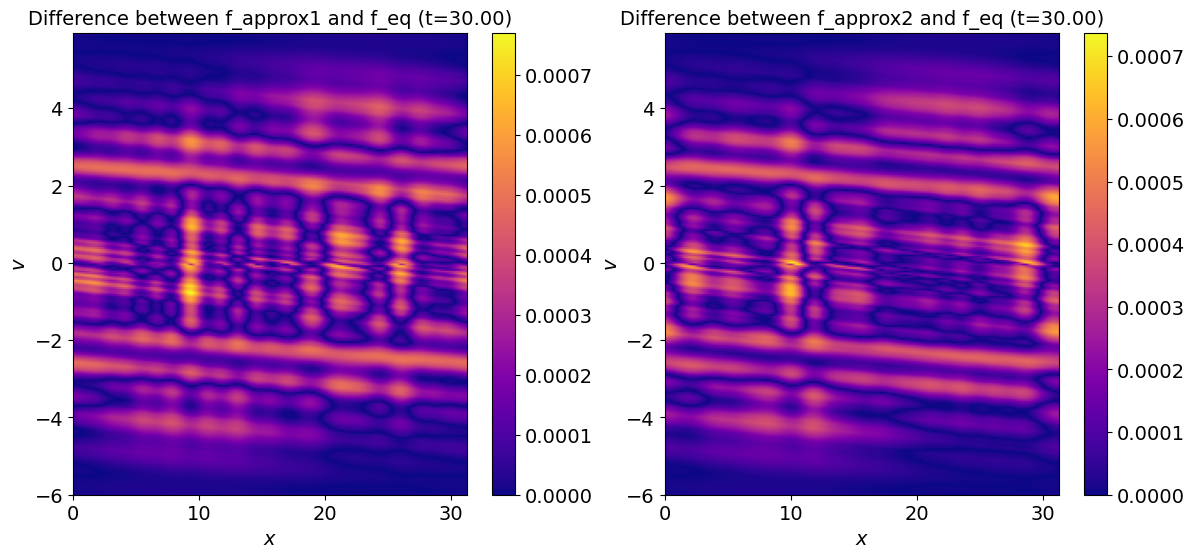

In [18]:
H_init_1 = compute_external_field(ak_init_1, mesh)
H_init_2 = compute_external_field(ak_init_2, mesh)
H_kl_1 = compute_external_field(ak_opt_kl_1, mesh)
H_kl_2 = compute_external_field(ak_opt_kl_2, mesh)
ff_array1, E_array1, ee_array1 = solver.run_forward_jax_scan(f_iv, H_kl_1, t_final)
ff_array2, E_array2, ee_array2 = solver.run_forward_jax_scan(f_iv, H_kl_2, t_final)

f_final1 = ff_array1
f_final2 = ff_array2


plt.plot(mesh.xs, H_init_1, label='Init 1')
plt.plot(mesh.xs, H_init_2, label='Init 2')
plt.xlabel('$x$')
plt.ylabel('$H(x)$')
plt.title('Initial external electric field $H(x)$')
plt.legend()
plt.show()

plt.plot(mesh.xs, H_kl_1, label='Init 1')
plt.plot(mesh.xs, H_kl_2, label='Init 2')
plt.xlabel('$x$')
plt.ylabel('$H(x)$')
plt.title('External electric field $H(x)$')
plt.legend()
plt.show()

# Plot the convergence
#objective_values_kl = jax.device_get(objective_values_kl)  # Move from device to host
plt.plot(objective_values_kl_1, label='Init 1')
plt.plot(objective_values_kl_2, label='Init 2')
plt.yscale('log')
plt.xlabel("Iteration")
plt.ylabel("KL")
plt.title("Convergence of Objective Function")
plt.legend()
plt.show()


plt.plot(t_values, ee_array1, label='Init 1')
plt.plot(t_values, ee_array2, label='Init 2')
plt.xlabel('Time')
plt.ylabel('Electric Energy')
plt.title('Electric Energy vs Time')
plt.legend()
#plt.grid(True)
plt.show()

# Create a figure for two subplots
fig, axs = plt.subplots(1,2 ,figsize=(14, 6))


plot_distribution(fig, axs[0], f_final1, 'With External Field 1', t_final)
plot_distribution(fig, axs[1], f_final2, 'With External Field 2', t_final)

plt.show()

fig, axs = plt.subplots(1,2 ,figsize=(14, 6))

plot_distribution(fig, axs[0], jnp.abs(f_final1 - f_eq), 'Difference between f_approx1 and f_eq', t_final)
plot_distribution(fig, axs[1], jnp.abs(f_final2 - f_eq), 'Difference between f_approx2 and f_eq', t_final)
plt.show()

### Electric energy objective function

In [22]:
# Optimization through auto-differentiation with fixed basis.

def electric_energy_opt(ee_array, solver):
    return jnp.sum(ee_array)*solver.dt

def cost_function_ee(a_k):
    H = compute_external_field(a_k, mesh)
    # JIT-compiled forward solver
    #solver_jit = jax.jit(solver.run_forward_jax_scan, static_argnames=('t_final',))
    f_array, E_array, ee_array = solver_jit(f_iv, H, t_final)
    #f_final = f_array
    cost = electric_energy_opt(ee_array, solver)
    return cost

In [23]:
maxiter = 250
solver_opt = jaxopt.LBFGS(fun=cost_function_ee, maxiter=maxiter)

# Define a scan function to iterate with `jax.lax.scan`
def scan_fn(carry, _):
    x, state = carry
    x, state = solver_opt.update(x, state)
    obj_value = cost_function_ee(x)
    return (x, state), obj_value

In [24]:
# Initial point and state
# External field parameters (coefficients for the cosine terms)
# Initial guess for the coefficients
k_total = 14
ak_init_1 = jax.random.uniform(jax.random.key(888), (2, k_total), minval=-1.0, maxval=1.0)
init_state = solver_opt.init_state(ak_init_1)

# Run the optimization and collect objective values using `scan`
res_opt_ee_1, objective_values_ee_1 = jax.lax.scan(scan_fn, (ak_init_1, init_state), None, length=solver_opt.maxiter)


ak_opt_ee_1, state = res_opt_ee_1

In [25]:
# Initial point and state
# External field parameters (coefficients for the cosine terms)
# Initial guess for the coefficients
k_total = 14
ak_init_2 = jax.random.uniform(jax.random.key(0), (2, k_total), minval=-1.0, maxval=1.0)
init_state = solver_opt.init_state(ak_init_2)

# Run the optimization and collect objective values using `scan`
res_opt_ee_2, objective_values_ee_2 = jax.lax.scan(scan_fn, (ak_init_2, init_state), None, length=solver_opt.maxiter)


ak_opt_ee_2, state = res_opt_ee_2

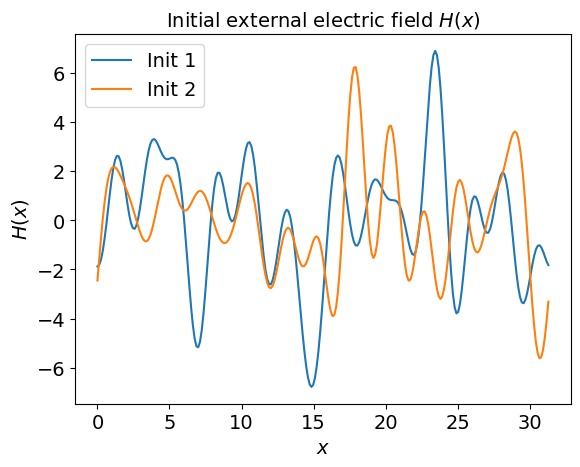

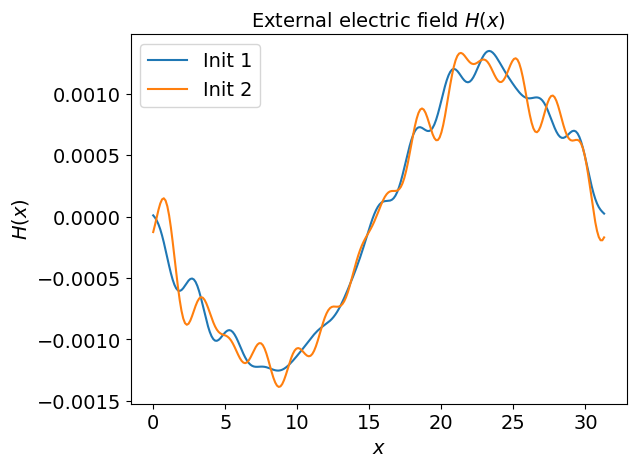

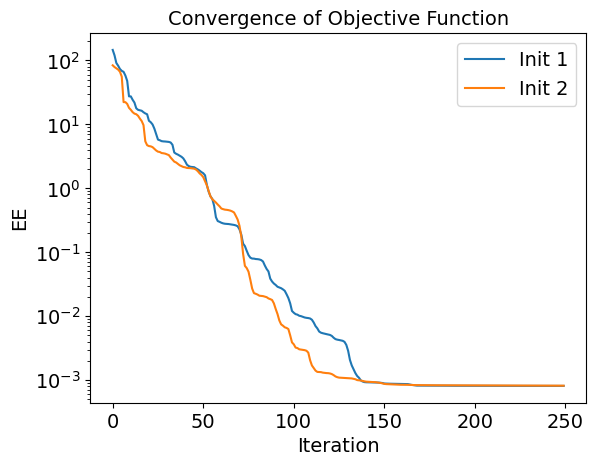

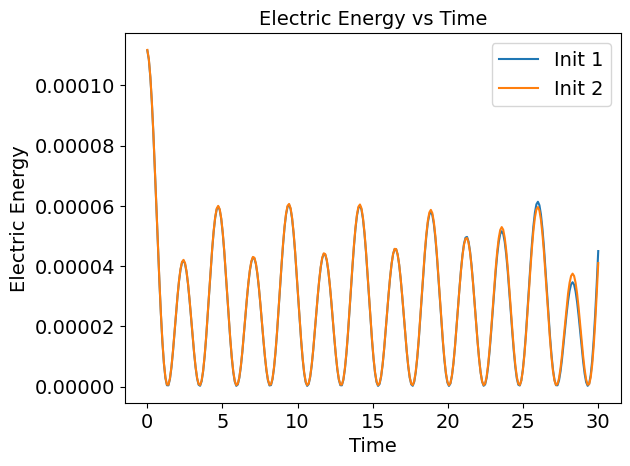

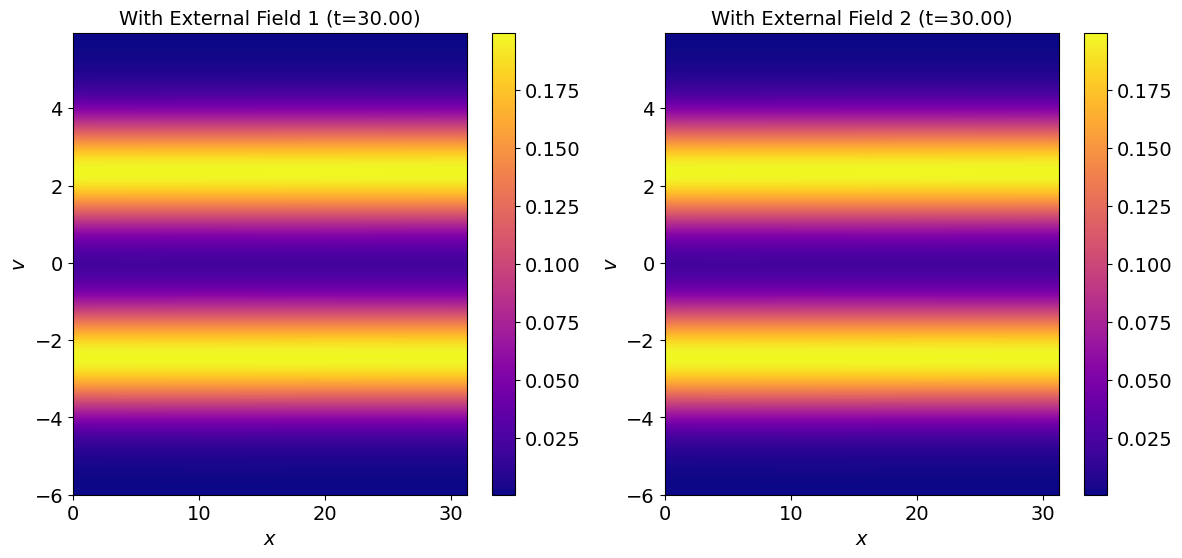

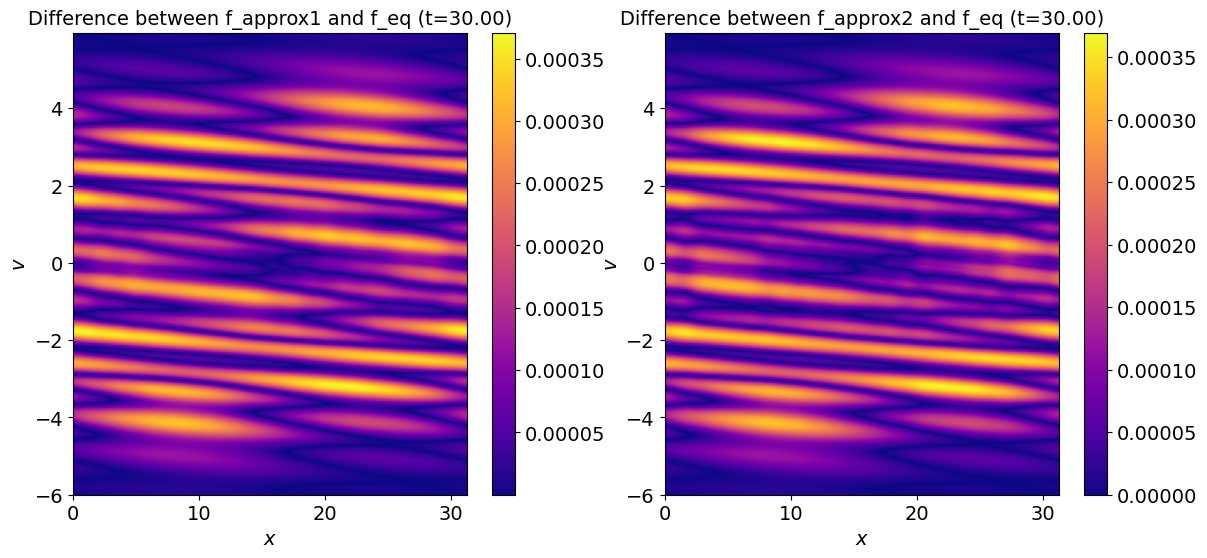

In [26]:
H_init_1 = compute_external_field(ak_init_1, mesh)
H_init_2 = compute_external_field(ak_init_2, mesh)
H_ee_1 = compute_external_field(ak_opt_ee_1, mesh)
H_ee_2 = compute_external_field(ak_opt_ee_2, mesh)
ff_array1, E_array1, ee_array1 = solver.run_forward_jax_scan(f_iv, H_ee_1, t_final)
ff_array2, E_array2, ee_array2 = solver.run_forward_jax_scan(f_iv, H_ee_2, t_final)

f_final1 = ff_array1
f_final2 = ff_array2


plt.plot(mesh.xs, H_init_1, label='Init 1')
plt.plot(mesh.xs, H_init_2, label='Init 2')
plt.xlabel('$x$')
plt.ylabel('$H(x)$')
plt.title('Initial external electric field $H(x)$')
plt.legend()
plt.show()

plt.plot(mesh.xs, H_ee_1, label='Init 1')
plt.plot(mesh.xs, H_ee_2, label='Init 2')
plt.xlabel('$x$')
plt.ylabel('$H(x)$')
plt.title('External electric field $H(x)$')
plt.legend()
plt.show()

# Plot the convergence
#objective_values_ee = jax.device_get(objective_values_ee)  # Move from device to host
plt.plot(objective_values_ee_1, label='Init 1')
plt.plot(objective_values_ee_2, label='Init 2')
plt.yscale('log')
plt.xlabel("Iteration")
plt.ylabel("EE")
plt.title("Convergence of Objective Function")
plt.legend()
plt.show()


plt.plot(t_values, ee_array1, label='Init 1')
plt.plot(t_values, ee_array2, label='Init 2')
plt.xlabel('Time')
plt.ylabel('Electric Energy')
plt.title('Electric Energy vs Time')
#plt.grid(True)
plt.legend()
plt.show()

# Create a figure for two subplots
fig, axs = plt.subplots(1,2 ,figsize=(14, 6))


plot_distribution(fig, axs[0], f_final1, 'With External Field 1', t_final)
plot_distribution(fig, axs[1], f_final2, 'With External Field 2', t_final)

plt.show()

fig, axs = plt.subplots(1,2 ,figsize=(14, 6))

plot_distribution(fig, axs[0], jnp.abs(f_final1 - f_eq), 'Difference between f_approx1 and f_eq', t_final)
plot_distribution(fig, axs[1], jnp.abs(f_final2 - f_eq), 'Difference between f_approx2 and f_eq', t_final)
plt.show()

### $W_{2}^{2}$ objective function

In [29]:
def wasserstein2(f_final, solver):
    """
    Compute the Wasserstein-2 distance.

    Args:
        density1: 2D array representing the first density function (evaluated on a grid).
        density2: 2D array representing the second density function (evaluated on a grid).

    Returns:
        The Wasserstein-2 distance between the two density functions.
    """
    # Ensure the densities are normalized
    f_final = f_final / jnp.sum(f_final * solver.mesh.dx * solver.mesh.dv)
    f_eq = solver.f_eq / jnp.sum(solver.f_eq * solver.mesh.dx * solver.mesh.dv)

    # Create a grid of points
    points = jnp.column_stack([solver.mesh.X.ravel(), solver.mesh.V.ravel()])

    # Flatten the densities
    mu = f_final.ravel()
    nu = f_eq.ravel()

    # Define the geometry of the optimal transport problem
    geom = pointcloud.PointCloud(points, points, epsilon=1e-3)

    # Create a linear transport problem
    problem = linear_problem.LinearProblem(geom, a=mu, b=nu)

    # Solve the problem using the Sinkhorn algorithm
    solver = sinkhorn.Sinkhorn()
    solution = solver(problem)


    return solution.reg_ot_cost


def cost_function_w2(a_k):
    H = compute_external_field(a_k, mesh)
    # JIT-compiled forward solver
    #solver_jit = jax.jit(solver.run_forward_jax_scan, static_argnames=('t_final',))
    f_array, E_array, ee_array = solver_jit(f_iv, H, t_final)
    #f_final = f_array
    cost = wasserstein2(f_array, solver)
    return cost

In [1]:
#maxiter = 2000
#solver_opt = jaxopt.LBFGS(fun=cost_function_w2, maxiter=maxiter)

# Define a scan function to iterate with `jax.lax.scan`
#def scan_fn(carry, _):
#    x, state = carry
#    x, state = solver_opt.update(x, state)
#    obj_value = cost_function_w2(x)
#    return (x, state), obj_value

# Initial point and state
# External field parameters (coefficients for the cosine terms)
# Initial guess for the coefficients
#k_total = 14
#ak_init = jax.random.uniform(jax.random.key(888), (2, k_total), minval=-1.0, maxval=1.0)
#init_state = solver_opt.init_state(ak_init)


# Run the optimization and collect objective values using `scan`
#res_opt_w2, objective_values_w2 = jax.lax.scan(scan_fn, (ak_init, init_state), None, length=solver_opt.maxiter)


#ak_opt_w2, state = res_opt_w2

In [2]:
#H_init = compute_external_field(ak_init, mesh)
#H_w2 = compute_external_field(ak_opt_ee, mesh)
#ff_array, E_array, ee_array = solver.run_forward_jax_scan(f_iv, H_w2, t_final)
    
#f_final = ff_array


#plt.plot(mesh.xs, H_init)
#plt.xlabel('$x$')
#plt.ylabel('$H(x)$')
#plt.title('Initial external electric field $H(x)$')
#plt.show()

#plt.plot(mesh.xs, H_w2)
#plt.xlabel('$x$')
#plt.ylabel('$H(x)$')
#plt.title('External electric field $H(x)$')
#plt.show()

# Plot the convergence
#objective_values_w2 = jax.device_get(objective_values_w2)  # Move from device to host
#plt.plot(objective_values_w2)
#plt.yscale('log')
#plt.xlabel("Iteration")
#plt.ylabel("KL")
#plt.title("Convergence of Objective Function")
#plt.show()


#plt.plot(t_values, ee_array)
#plt.xlabel('Time')
#plt.ylabel('Electric Energy')
#plt.title('Electric Energy vs Time')
#plt.grid(True)
#plt.show()

# Plot the distribution at the final time for the current iteration
#fig, ax = plt.subplots(figsize=(8, 6))
#plot_distribution(ax, f_final, 'With External Field', t_final)
#plt.show()

#fig, ax = plt.subplots(figsize=(8, 6))
#plot_distribution(ax, jnp.abs(f_final - f_eq), 'Difference between f_approx and f_eq', t_final)
#plt.show()

### Comparing metrics

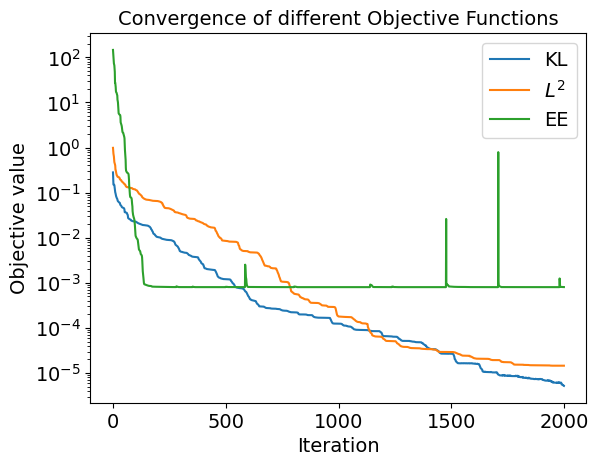

In [20]:
plt.plot(objective_values_kl, label='KL')
plt.plot(objective_values_l2, label='$L^2$')
plt.plot(objective_values_ee, label='EE')
#plt.plot(objective_values_w2, label='$W_2^2$')
plt.yscale('log')
plt.xlabel("Iteration")
plt.ylabel("Objective value")
plt.title("Convergence of different Objective Functions")
plt.legend()
plt.show()